# Music Genre Classifier


In [1]:
import os
import cv2
import random
import shutil
import zipfile
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from pandas import DataFrame
from keras import Sequential
from sklearn.model_selection import train_test_split, KFold
from keras.layers import Conv2D, UpSampling2D, MaxPooling2D, Input, Cropping2D, Cropping3D, Flatten, Dense, Reshape

In [2]:
SEED_VALUE = 42

# Fix seed to make training deterministic.
random.seed(SEED_VALUE)
np.random.seed(SEED_VALUE)
tf.random.set_seed(SEED_VALUE)

## Load the GTZAN Dataset


In [3]:
if os.getenv('COLAB_RELEASE_TAG'):
    from google.colab import drive
    drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
PREPROCESSING = False

try:
    if 'dataset' not in os.listdir('/content'):
        os.mkdir('/content/dataset/')
    pwd = os.getcwd()
    os.chdir('/content/dataset/')

    if 'gtzan-features.zip' not in os.listdir('.'):
        if os.getenv('COLAB_RELEASE_TAG'):
            if 'gtzan-features.zip' in os.listdir('/content/gdrive/MyDrive'):
                shutil.copy2('/content/gdrive/MyDrive/gtzan-features.zip', '.')
            else:
                # make sure to download the GTZAN dataset from "https://drive.google.com/file/d/1LDlvwUeJ-h3JntNSmQABNV8z8oqltojO/view?usp=drive_link"
                # upload it to your own google drive for it to be copied in the previous if statement block
                pass
        else:
            if pwd != '/content/dataset':
                if 'gtzan-features.zip' in os.listdir(f'{pwd}/dataset'):
                    shutil.copy2(f'{pwd}/dataset/gtzan-features.zip', '.')
                else:
                    raise Exception("Download the GTZAN dataset preprocessed.")

        with zipfile.ZipFile('gtzan-features.zip', 'r') as zip_ref:
            zip_ref.extractall('.')

finally:
    GENRES = os.listdir('/content/dataset/training/mfcc')


## Dataset


In [5]:
def load_data(src: str, feature: str, 
              random_state: float = SEED_VALUE, shuffle: bool = True, 
              stratify: list = None):
    dataset = []
    for genre in os.listdir(f'{src}/{feature}'):
        for img in os.listdir(f'{src}/{feature}/{genre}'):
            img = cv2.imread(f'{src}/{feature}/{genre}/{img}')
            img = cv2.resize(img, (256, 192))
            img = np.array(img, dtype=np.float32)
            dataset.append([img, genre])

    df = DataFrame(data=np.array(dataset, dtype=object), columns=[feature, 'genre'])

    one_hot = pd.get_dummies(df['genre'])

    df = pd.concat([df, one_hot], axis=1)
    df.drop(['genre'], axis=1, inplace=True)

    return (np.array([tf.convert_to_tensor(img) for img in df['mfcc']]), df[GENRES])

In [6]:
(X_train, _) = load_data('./training/', 'mfcc', stratify=GENRES)
(X_test, _) = load_data('./tests/', 'mfcc', stratify=GENRES)
(X_val, _) = load_data('./validation/', 'mfcc', stratify=GENRES)

# for cross validation purposes it is encouraged to concatenate all input/output data, in this case, only input
X_all = np.concatenate((X_train, X_test), axis=0)
X_all = np.concatenate((X_all, X_val), axis=0)
# this is just to normalize the values between 0 and 1
X_train = X_train / 255
X_test = X_test / 255
X_val = X_val / 255
X_all = X_all / 255

## CNN Autoencoder


In [7]:
def generate_autoencoder():
    input_l=Input(shape=(192, 256, 3))

    maxp_ini=MaxPooling2D((4,4), padding='same', strides=(2, 2))(input_l)
    encoding_1=Conv2D(12, (3,3), activation='relu',padding='same')(maxp_ini)

    maxp_1=MaxPooling2D((2,2), padding='same')(encoding_1)
    encoding_2=Conv2D(6, (3,3), activation='relu',padding='same')(maxp_1)

    maxp_2=MaxPooling2D((2,2), padding='same')(encoding_2)
    encoding_3=Conv2D(3, (3,3), activation='relu',padding='same')(maxp_2)

    flat_1=Flatten()(encoding_3)

    bottleneck=Dense(500)(flat_1)

    decoding_1=Dense(2304, activation='relu')(bottleneck)
    resh_1=Reshape(target_shape=(24, 32, 3)) (decoding_1)

    decoding_2=Conv2D(6, (3,3), activation='relu', padding='same')(resh_1)
    Up_1=UpSampling2D((2,2))(decoding_2)

    decoding_3=Conv2D(12, (3,3), activation='relu', padding='same')(Up_1)
    Up_2=UpSampling2D((2,2))(decoding_3)

    decoding_4=Conv2D(3, (3,3), activation='relu', padding='same')(Up_2)
    output_l=UpSampling2D((2,2))(decoding_4)

    autoencoder=Model(inputs=[input_l],outputs=[output_l])

    autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])

    return autoencoder

In [8]:
generate_autoencoder().summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 192, 256, 3)]     0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 96, 128, 3)       0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 96, 128, 12)       336       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 64, 12)       0         
 2D)                                                             
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 64, 6)         654       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 24, 32, 6)        0     

In [9]:
model_storage = '/content'

if os.getenv('COLAB_RELEASE_TAG'):
    model_storage = '/content/gdrive/MyDrive'

if 'model_storage_final' not in os.listdir(model_storage):
    os.mkdir(f'{model_storage}/model_storage_final')

model_storage='/content/gdrive/MyDrive/model_storage_final'

## Training and Cross Validating

In [10]:
autoencoder = generate_autoencoder()
last_iter = 0
iter_num = 15

if len([autoencoder for autoencoder in os.listdir(model_storage) if autoencoder[:19]=='autoencoder_model2_']) > 0:
    last_iter = sorted([int(autoencoder.removeprefix(f'autoencoder_model2_').removesuffix('.keras'))
        for autoencoder in os.listdir(model_storage) if autoencoder[:19]=='autoencoder_model2_'], reverse=True)[0]
    autoencoder = tf.keras.saving.load_model(f'{model_storage}/autoencoder_model2_{last_iter}.keras')
    last_iter+=1 #this is for not overwriting the last saved model

for i in range(last_iter, iter_num):
    autoencoder.fit(x=X_train, y=X_train, epochs=10, validation_data=(X_test, X_test))
    autoencoder.save(f'{model_storage}/autoencoder_model2_{i}.keras')

# Generate validation set metrics
scores = autoencoder.evaluate(X_val, X_val, verbose=0)
print(f'Score for validation set: {autoencoder.metrics_names[0]} of {scores[0]}')

Score for validation set: loss of 0.0018654228188097477


In [11]:
kfold=KFold(n_splits=10, shuffle=True)
kfold_splits=[]

for train, test in kfold.split(X_all, X_all):
    kfold_splits.append((train, test))

Score for fold 1: loss of 0.0015978243900462985
Score for fold 2: loss of 0.001570885768160224
Score for fold 3: loss of 0.0015570692485198379
Score for fold 4: loss of 0.0015928276116028428
Score for fold 5: loss of 0.00165411620400846
Score for fold 6: loss of 0.0015304619446396828
Score for fold 7: loss of 0.0015729523729532957
Score for fold 8: loss of 0.0015823842259123921
Score for fold 9: loss of 0.001667478703893721
Score for fold 10: loss of 0.0016295399982482195


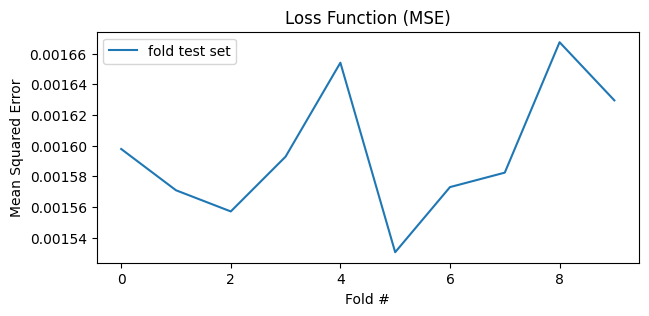

In [12]:
fold_no=1
final_errors_per_fold=[]

for train, test in kfold_splits:
    last_iter = 0

    autoencoder = generate_autoencoder()

    if f'fold_{fold_no}' not in os.listdir(model_storage):
        os.mkdir(f'{model_storage}/fold_{fold_no}')

    if len([autoencoder for autoencoder in os.listdir(f'{model_storage}/fold_{fold_no}') if autoencoder[:19]=='autoencoder_model2_']) > 0:
        last_iter = sorted([int(autoencoder.removeprefix(f'autoencoder_model2_').removesuffix('.keras'))
            for autoencoder in os.listdir(f'{model_storage}/fold_{fold_no}') if autoencoder[:19]=='autoencoder_model2_'], reverse=True)[0]
        autoencoder = tf.keras.saving.load_model(f'{model_storage}/fold_{fold_no}/autoencoder_model2_{last_iter}.keras')
        last_iter+=1 #this is for not overwriting the last saved model

    for i in range(last_iter, iter_num):
        autoencoder.fit(x=X_all[train], y=X_all[train], epochs=10)
        autoencoder.save(f'{model_storage}/fold_{fold_no}/autoencoder_model2_{i}.keras')

    # Generate generalization metrics
    scores = autoencoder.evaluate(X_all[test], X_all[test], verbose=0)
    print(f'Score for fold {fold_no}: {autoencoder.metrics_names[0]} of {scores[0]}')
    final_errors_per_fold.append(scores[0])

    # Increase fold number
    fold_no = fold_no + 1


plt.figure(figsize=(7,3))

plt.plot(final_errors_per_fold, label='fold test set')
plt.title('Loss Function (MSE)')
plt.xlabel('Fold #')
plt.ylabel('Mean Squared Error')
plt.legend()

plt.show()

## Overfitting analysis

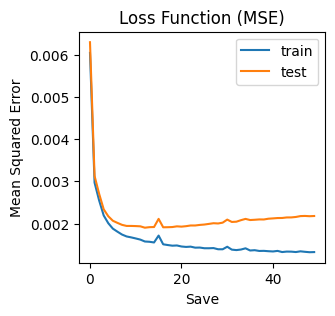

In [13]:
autoencoder = generate_autoencoder()
last_iter = 0
iter_num = 50
history_train=[]
history_test=[]

for i in range(last_iter, iter_num):
    if f'overfitting_analysis_{i}.keras' in [autoencoder for autoencoder in os.listdir(model_storage)]:
        autoencoder = tf.keras.saving.load_model(f'{model_storage}/overfitting_analysis_{i}.keras')
    else:
        autoencoder.fit(x=X_train, y=X_train, epochs=10, validation_data=(X_test, X_test))

    scores_train = autoencoder.evaluate(X_train, X_train, verbose=0)
    history_train.append(scores_train[0])

    scores_test = autoencoder.evaluate(X_test, X_test, verbose=0)
    history_test.append(scores_test[0])

    if f'overfitting_analysis_{i}.keras' not in [autoencoder for autoencoder in os.listdir(model_storage)]:
        autoencoder.save(f'{model_storage}/overfitting_analysis_{i}.keras')

plt.figure(figsize=(7,3))

plt.subplot(1,2,1)
plt.plot(history_train, label='train')
plt.plot(history_test, label='test')
plt.title('Loss Function (MSE)')
plt.xlabel('Save')
plt.ylabel('Mean Squared Error')
plt.legend()

plt.show()

## Encoder

In [14]:
def build_encoder(autoencoder_name):
    if autoencoder_name not in os.listdir(model_storage):
        print(f'Not finished optimizing: {autoencoder_name} not found in {model_storage}.')
    else:
        autoencoder = tf.keras.saving.load_model(f'{model_storage}/{autoencoder_name}')
        encoder_input_l = Input(shape=(192,256,3))
        res_1 = autoencoder.layers[1](encoder_input_l)
        res_2 = autoencoder.layers[2](res_1)
        res_3 = autoencoder.layers[3](res_2)
        res_4 = autoencoder.layers[4](res_3)
        res_5 = autoencoder.layers[5](res_4)
        res_6 = autoencoder.layers[6](res_5)
        res_7 = autoencoder.layers[7](res_6)
        encoder_output_l = autoencoder.layers[8](res_7)
        encoder=Model(inputs=[encoder_input_l],outputs=[encoder_output_l])
        return encoder

# if necessary, download this precise autoencoder model from https://drive.google.com/file/d/12gtgkBgo_n1SF6LKLzNsXgtTuN_Wcoqn/view?usp=sharing
encoder = build_encoder('autoencoder_model2_14.keras')
# encoder is already saved at https://drive.google.com/file/d/11odRe5Stk9x8BWTv5Y2x8TFvgT_iuuZs/view?usp=sharing
encoder.save(f'{model_storage}/encoder_model.keras')

print(encoder(X_train[:1])) # test

tf.Tensor(
[[-1.18611023e-01 -1.45410048e-02 -5.16168922e-02 -4.52646567e-03
  -4.99989726e-02 -7.06644058e-02 -3.11843283e-03 -4.38341033e-03
  -2.80506182e-02  2.21636109e-02  8.64882395e-02 -4.17456701e-02
  -9.94971767e-03 -9.43090618e-02  2.93995552e-02  2.19417401e-02
   1.31567428e-03 -7.63638411e-04  2.92655756e-03 -4.30082381e-02
   3.23323719e-02 -1.55457165e-02  4.31308560e-02 -7.86170736e-03
   2.36294307e-02  2.09259838e-02 -6.51268959e-02 -1.53439911e-02
   1.52383018e-02  8.71672761e-03 -6.99814111e-02 -7.76365958e-03
  -2.90662870e-02  3.03099323e-02 -8.47542100e-03 -1.85869876e-02
   2.77502853e-02 -1.57598153e-01  5.93213141e-02 -2.69710291e-02
   1.49233630e-02  4.16679196e-02  1.13350414e-02  3.64209414e-02
  -1.59923866e-01  9.16383937e-02  4.17865217e-02 -2.42226236e-02
  -5.81484102e-03  6.14931583e-02  2.53466796e-02  5.52394167e-02
  -9.32426304e-02 -2.39038691e-02  1.70433186e-02 -1.20908096e-02
   2.03561224e-02 -3.58801102e-04  3.55606303e-02  2.46872520e-03